In [1]:
from pyspark.sql import SparkSession, Row
from pyspark import SparkFiles
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
spark = SparkSession.builder.appName('MySparkApp').getOrCreate()

In [3]:
spark.sparkContext.addFile('https://www.gutenberg.org/cache/epub/1513/pg1513.txt')
spark.sparkContext.addFile('https://www.gutenberg.org/cache/epub/23042/pg23042.txt')
spark.sparkContext.addFile('https://www.gutenberg.org/cache/epub/27761/pg27761.txt')

In [4]:
rj_df = spark.read.text(SparkFiles.get('pg1513.txt'))
t_df = spark.read.text(SparkFiles.get('pg23042.txt'))
h_df = spark.read.text(SparkFiles.get('pg27761.txt'))

In [5]:
rj_df.show()
t_df.show()
h_df.show()

+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m...|
|of the Project Gu...|
|at www.gutenberg....|
|you will have to ...|
|before using this...|
|                    |
|Title: Romeo and ...|
|                    |
|Author: William S...|
|                    |
|Release date: Nov...|
|                M...|
|                    |
|   Language: English|
|                    |
|Credits: the PG S...|
+--------------------+
only showing top 20 rows

+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m...|
|of the Project Gu...|
|at www.gutenberg....|
|you will have to ...|
|before using this...|
|                    |
|  Title: The Tempest|
|                    |
|Author: William S...|
|                    |
|Editor: William G...|
|       

## PySpark Steps
### Data Cleaning

In [6]:
rj_df = rj_df.withColumn('play', F.lit('Romeo and Juliet'))
t_df = t_df.withColumn('play', F.lit('The Tempest'))
h_df = h_df.withColumn('play', F.lit('Hamlet'))

In [7]:
df = rj_df.union(t_df)
df = df.union(h_df)

In [8]:
df.show()

+--------------------+----------------+
|               value|            play|
+--------------------+----------------+
|The Project Guten...|Romeo and Juliet|
|                    |Romeo and Juliet|
|This ebook is for...|Romeo and Juliet|
|most other parts ...|Romeo and Juliet|
|whatsoever. You m...|Romeo and Juliet|
|of the Project Gu...|Romeo and Juliet|
|at www.gutenberg....|Romeo and Juliet|
|you will have to ...|Romeo and Juliet|
|before using this...|Romeo and Juliet|
|                    |Romeo and Juliet|
|Title: Romeo and ...|Romeo and Juliet|
|                    |Romeo and Juliet|
|Author: William S...|Romeo and Juliet|
|                    |Romeo and Juliet|
|Release date: Nov...|Romeo and Juliet|
|                M...|Romeo and Juliet|
|                    |Romeo and Juliet|
|   Language: English|Romeo and Juliet|
|                    |Romeo and Juliet|
|Credits: the PG S...|Romeo and Juliet|
+--------------------+----------------+
only showing top 20 rows



1. Separate the words

In [9]:
df = df.select(F.split(df.value, '\ ').alias('word'), df.play)

In [10]:
df.show()

+--------------------+----------------+
|                word|            play|
+--------------------+----------------+
|[The, Project, Gu...|Romeo and Juliet|
|          [, , , , ]|Romeo and Juliet|
|[This, ebook, is,...|Romeo and Juliet|
|[most, other, par...|Romeo and Juliet|
|[whatsoever., You...|Romeo and Juliet|
|[of, the, Project...|Romeo and Juliet|
|[at, www.gutenber...|Romeo and Juliet|
|[you, will, have,...|Romeo and Juliet|
|[before, using, t...|Romeo and Juliet|
|                  []|Romeo and Juliet|
|[Title:, Romeo, a...|Romeo and Juliet|
|                  []|Romeo and Juliet|
|[Author:, William...|Romeo and Juliet|
|                  []|Romeo and Juliet|
|[Release, date:, ...|Romeo and Juliet|
|[, , , , , , , , ...|Romeo and Juliet|
|                  []|Romeo and Juliet|
|[Language:, English]|Romeo and Juliet|
|                  []|Romeo and Juliet|
|[Credits:, the, P...|Romeo and Juliet|
+--------------------+----------------+
only showing top 20 rows



In [11]:
df = df.select(F.explode(df.word).alias('word'), df.play)

In [12]:
df.show()

+---------+----------------+
|     word|            play|
+---------+----------------+
|      The|Romeo and Juliet|
|  Project|Romeo and Juliet|
|Gutenberg|Romeo and Juliet|
|    eBook|Romeo and Juliet|
|       of|Romeo and Juliet|
|    Romeo|Romeo and Juliet|
|      and|Romeo and Juliet|
|   Juliet|Romeo and Juliet|
|         |Romeo and Juliet|
|         |Romeo and Juliet|
|         |Romeo and Juliet|
|         |Romeo and Juliet|
|         |Romeo and Juliet|
|     This|Romeo and Juliet|
|    ebook|Romeo and Juliet|
|       is|Romeo and Juliet|
|      for|Romeo and Juliet|
|      the|Romeo and Juliet|
|      use|Romeo and Juliet|
|       of|Romeo and Juliet|
+---------+----------------+
only showing top 20 rows



2. Remove punctuation

In [13]:
df = df.select(F.regexp_replace(df.word, r'[^\w]', '').alias('word'), df.play)

In [14]:
df.show()

+---------+----------------+
|     word|            play|
+---------+----------------+
|      The|Romeo and Juliet|
|  Project|Romeo and Juliet|
|Gutenberg|Romeo and Juliet|
|    eBook|Romeo and Juliet|
|       of|Romeo and Juliet|
|    Romeo|Romeo and Juliet|
|      and|Romeo and Juliet|
|   Juliet|Romeo and Juliet|
|         |Romeo and Juliet|
|         |Romeo and Juliet|
|         |Romeo and Juliet|
|         |Romeo and Juliet|
|         |Romeo and Juliet|
|     This|Romeo and Juliet|
|    ebook|Romeo and Juliet|
|       is|Romeo and Juliet|
|      for|Romeo and Juliet|
|      the|Romeo and Juliet|
|      use|Romeo and Juliet|
|       of|Romeo and Juliet|
+---------+----------------+
only showing top 20 rows



3. Filter non-words

In [15]:
df = df.filter(df.word != '')

In [16]:
df = df.select(F.lower(df.word).alias('word'), df.play)

In [17]:
df.show()

+---------+----------------+
|     word|            play|
+---------+----------------+
|      the|Romeo and Juliet|
|  project|Romeo and Juliet|
|gutenberg|Romeo and Juliet|
|    ebook|Romeo and Juliet|
|       of|Romeo and Juliet|
|    romeo|Romeo and Juliet|
|      and|Romeo and Juliet|
|   juliet|Romeo and Juliet|
|     this|Romeo and Juliet|
|    ebook|Romeo and Juliet|
|       is|Romeo and Juliet|
|      for|Romeo and Juliet|
|      the|Romeo and Juliet|
|      use|Romeo and Juliet|
|       of|Romeo and Juliet|
|   anyone|Romeo and Juliet|
| anywhere|Romeo and Juliet|
|       in|Romeo and Juliet|
|      the|Romeo and Juliet|
|   united|Romeo and Juliet|
+---------+----------------+
only showing top 20 rows



### Word Counts
4. Total word count

In [18]:
word_count_df = df.groupBy('play').count()

In [19]:
word_count_df.show()

+----------------+-----+
|            play|count|
+----------------+-----+
|Romeo and Juliet|28989|
|     The Tempest|26415|
|          Hamlet|34879|
+----------------+-----+



In [20]:
grouped_count_df = df.groupBy('word').count()

In [21]:
grouped_count_df =  grouped_count_df.orderBy(F.desc('count'))

In [22]:
grouped_plays_df = df.groupBy(['word', 'play']).count()

In [23]:
grouped_plays_df = grouped_plays_df.orderBy(F.desc('count'))

In [24]:
grouped_count_df.show()
grouped_plays_df.show()

+----+-----+
|word|count|
+----+-----+
| the| 3184|
| and| 2239|
|  of| 1918|
|  to| 1898|
|   a| 1585|
|   i| 1492|
|  in| 1185|
| you| 1169|
|  my| 1045|
|  is|  950|
|that|  919|
|this|  813|
|with|  782|
|  it|  771|
| not|  768|
| for|  661|
|  me|  611|
|  be|  606|
|  as|  553|
|thou|  552|
+----+-----+
only showing top 20 rows

+--------+----------------+-----+
|    word|            play|count|
+--------+----------------+-----+
|     the|          Hamlet| 1463|
|      of|          Hamlet|  918|
|     the|Romeo and Juliet|  875|
|     the|     The Tempest|  846|
|      to|          Hamlet|  817|
|     and|Romeo and Juliet|  803|
|     and|          Hamlet|  800|
|       a|          Hamlet|  643|
|     and|     The Tempest|  636|
|      to|Romeo and Juliet|  622|
|       i|Romeo and Juliet|  580|
|       a|Romeo and Juliet|  541|
|      of|Romeo and Juliet|  518|
|     you|          Hamlet|  512|
|       i|     The Tempest|  504|
|      in|          Hamlet|  504|
|      of|     T

### Analyze with Pandas
4. Convert the Spark DataFrame to a Pandas DataFrame

In [25]:
grouped_count_df = grouped_count_df.toPandas()

Display a word cloud with the top 50 words

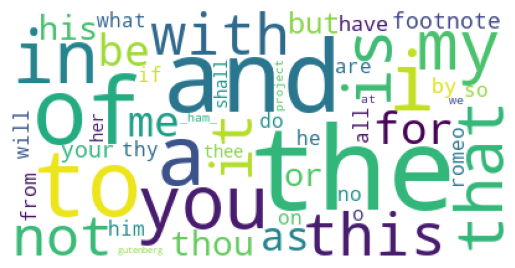

In [26]:
top_words_df = grouped_count_df.iloc[:50]
frequencies = pd.Series(top_words_df['count'].values, index=top_words_df['word']).to_dict()
wc = WordCloud(background_color='white')
wc. generate_from_frequencies(frequencies)
plt.imshow(wc)
plt.axis('off')
plt.show()

Create a histogram of the top 50 word counts.


<Axes: ylabel='Count'>

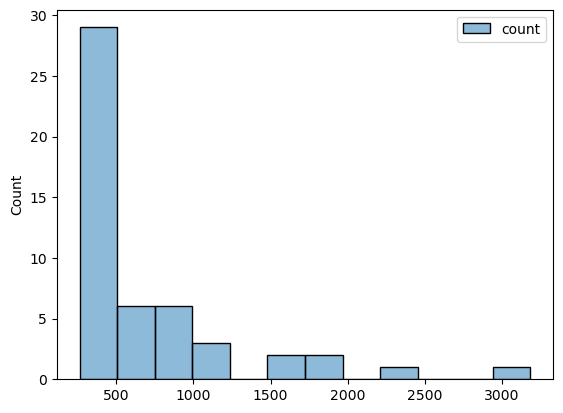

In [29]:
sns.histplot(top_words_df)